# TP Formation Python

L'objectif du TP est d'écrire un simulateur du taux de $CO_2$ dans une pièce, et donc :
* un module Python 
* son installeur
* ses tests
* sa documentation

**Modèle analytique du taux de $CO_2$ dans une pièce**

$$[CO_2]^{n+1} = \left( 1 - \frac{\dot{m}_v \Delta t}{\rho V_Z} - \frac{n_{occ} \dot{m}_{occ} \Delta t}{V_Z}\right) [CO_2]^n + \frac{n_{occ} \dot{m}_{occ} \Delta t}{V_Z} [CO_2]^{occ} + \frac{\dot{m}_v \Delta t}{\rho V_Z} [CO_2]^{ext}$$

où :
  * $[CO_2]^n$ et $[CO_2]^{n+1}$ sont les taux de $CO_2$ aux temps $t_n$ ety $t_{n+1}$ tels que $\Delta t = t_{n+1} - t_n$,
  * $n_{occ}$ est le nombre d'occupants au temps $t_n$,
  * $\dot{m}_v$ est le débit de renouvellement d'air par l'extérieur,
  * $\dot{m}_{occ}$ est le débit de respiration pris à $\dot{m}_{occ} = 10^{-4} m^3/s$,
  * $[CO_2]^{occ}$ est le taux de $CO_2$ dans l'air soufflé, pris à $[CO_2]^{occ} = 36000\,ppm$,
  * $[CO_2]^{ext}$ est le taux de $CO_2$ dans l'air extérieur,
  * $V_Z$ est le volume de la zone étudiée.
  
On pourra considérer le terme d'aspiration de $CO_2$ par les occupants $- \frac{n_{occ} \dot{m}_{occ} \Delta t}{V_Z} [CO_2]^n$ négligeable devant les termes de soufflage par les occupants et de renouvellement d'air, donnant :

$$[CO_2]^{n+1} = \left( 1 - \frac{\dot{m}_v \Delta t}{\rho V_Z}\right) [CO_2]^n + \frac{n_{occ} \dot{m}_{occ} \Delta t}{V_Z} [CO_2]^{occ} + \frac{\dot{m}_v \Delta t}{\rho V_Z} [CO_2]^{ext}$$

## Tests unitaires

Les tests qui suivent, associés au test métier, couvrent 100% des lignes de code d'un simulateur répondant à l'énoncé. Ils indiquent les noms des classes, les paramètres des constructeurs et des méthodes, ainsi que les exceptions qui doivent être levées par le code.

In [21]:
import pytest


def test_set_set_infiltration():
    from dummysim import Zone, Infiltration
    z = Zone('Zone1', 125)
    inf1 = Infiltration('Inf1', 0.01)
    inf2 = Infiltration('Inf2', 0.02)
    z.set_infiltration(inf1)

    with pytest.raises(RuntimeError):
        z.set_infiltration(inf2)


def test_remove_occupant():
    from dummysim import Zone, Occupant
    z = Zone('Zone1', 125)
    occ = Occupant('Occ1')

    with pytest.raises(ValueError):
        z.remove_occupant(occ)


def test_add_remove_occupant():
    from dummysim import Zone, Occupant
    z = Zone('Zone1', 125)
    occ = Occupant('Occ1')
    z.add_occupant(occ)
    z.remove_occupant(occ)
    assert(z.occupants == [])


def test_remove_ventilation():
    from dummysim import Zone, Ventilation
    z = Zone('Zone1', 125)
    ven = Ventilation('Ven1', 0.01)

    with pytest.raises(ValueError):
        z.remove_ventilation(ven)


def test_add_remove_ventilation():
    from dummysim import Zone, Ventilation
    z = Zone('Zone1', 125)
    ven = Ventilation('Ven1', 0.01)
    z.add_ventilation(ven)
    z.remove_ventilation(ven)
    assert(z.ventilations == [])


def test_set_unset_infiltration():
    from dummysim import Zone, Infiltration
    z = Zone('Zone1', 125)
    inf1 = Infiltration('Inf1', 0.01)
    z.set_infiltration(inf1)
    z.unset_infiltration()
    assert(z.infiltration is None)


def test_set_unset_unset_infiltration():
    from dummysim import Zone, Infiltration
    z = Zone('Zone1', 125)
    inf1 = Infiltration('Inf1', 0.01)
    z.set_infiltration(inf1)
    z.unset_infiltration()

    with pytest.raises(RuntimeError):
        z.unset_infiltration()

def test_sim_without_infiltration():
    from dummysim import Zone

    z = Zone('Zone1', 125)
    with pytest.raises(RuntimeError):
        z.sim(1)

## Test métier

L'objectif de ce test métier est de comparer la solution générée par le modèle à une solution exacte manufacturée du même problème. Le modèle calcul itérativement chaque taux de $CO_2$ à partir du précédent, tandis que la solution manufacturée utilise les propriétés du modèle pour calculer analytiquement le taux de $CO_2$ à tout instant.

En écrivant $u_n = \frac{[CO_2]^n}{[CO_2]^0}$, hors horaires de ventilation, le modèle s'écrit $u_{n+1} = a u_n + b$ avec $u_0 = 1$ et

$$a = \left( 1 - \frac{\dot{m}_{inf} \Delta t}{\rho V_Z} \right)$$

$$b = \frac{n_{occ} \dot{m}_{occ} \Delta t}{V_Z} [CO_2]^{occ} + \frac{\dot{m}_{inf} \Delta t}{\rho V_Z} [CO_2]^{ext}$$.

La suite arithmético-géométrique $(u_n)$ a pour terme général :

$$u_n = a^n \left(1 - \frac{b}{1-a}\right) + \frac{b}{1-a}$$

ce qui donne la méthode de calcul de $[CO_2]^n$ pour tout $n$.

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [18]:
initial_CO2 = 400
volume = 125
ven_flow_rate = volume*0.5*1.2/3600
inf_flow_rate = volume*0.5*1.2/3600
occ_flow_rate = 1e-4/1.2
outdoor_CO2 = 400
occ_CO2_rate = 36000

In [19]:
a = 1. - (ven_flow_rate + inf_flow_rate + occ_flow_rate) * 600./(1.2 * volume)
b = (ven_flow_rate + inf_flow_rate) * 600./(1.2 * volume) * outdoor_CO2 + occ_flow_rate * 600./(1.2 * volume) * occ_CO2_rate
r = b/(1. - a)
df_exact = pd.DataFrame(index=pd.date_range(start='01-january-2017', periods=1 * 24 * 6, freq='10MIN'))
df_exact['CO2'] = initial_CO2

idx = 0
for i in df_exact.index:
    df_exact.CO2.loc[i] = pow(a, idx) * (initial_CO2 - r) + r
    idx += 1

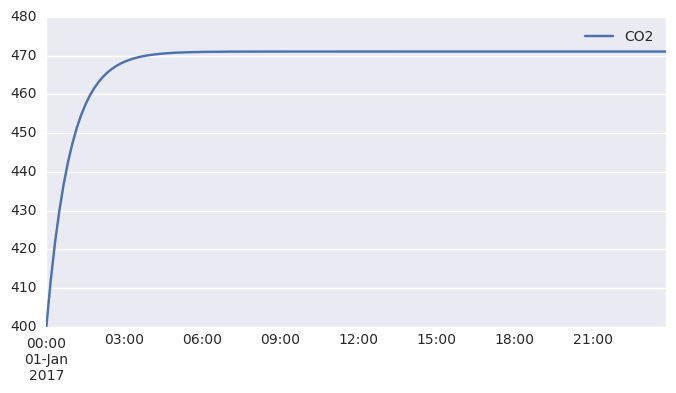

In [20]:
df_exact.plot(figsize=(8,4))